## Season Average notebook

Goal: for a given team, compute it's average network throughout the season. Can also cluster with k clusters, in order to find the k most similar tactics used

In [1]:
# Imports
import numpy as np, pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
import os
from pathlib import Path

In [2]:
df_events_net = pd.read_csv("df_events_net.csv")
df_match = pd.read_csv("df_match.csv")

In [3]:
_PERIOD_ORDER = {"1H": 1, "2H": 2, "E1": 3, "E2": 4, "P": 5}

def _abs_time(period: pd.Series, sec: pd.Series) -> pd.Series:
    base = period.map(_PERIOD_ORDER).fillna(99)
    return base * 1_000_000 + pd.to_numeric(sec, errors="coerce").fillna(0)

def _get_starting_xi(df_match: pd.DataFrame, match_id: int, team_id: int) -> list[int]:
    row = df_match.loc[df_match["match_id"] == match_id]
    if row.empty:
        raise ValueError(f"match_id {match_id} not found in df_match")
    row = row.iloc[0]
    is_home = int(row["home_team_id"]) == int(team_id)
    key = "home_players" if is_home else "away_players"
    players = row.get(key, None)

    if isinstance(players, str):
        try:
            players = json.loads(players)
        except Exception:
            players = None

    if isinstance(players, (list, tuple)) and len(players) >= 11:
        return list(pd.Series(players).dropna().astype(int).iloc[:11].values)
    return

def team_substitutions(df_events_net: pd.DataFrame, match_id: int, team_id: int) -> pd.DataFrame:
    subs = (df_events_net.query("match_id == @match_id and team_id == @team_id and event_name == 'Substitution'")
            .loc[:, ["event_id","period","event_sec","player_id","rel_player_id"]]
            .rename(columns={"player_id":"player_in","rel_player_id":"player_out"}))
    subs = subs.assign(abs_t=_abs_time(subs["period"], subs["event_sec"])) \
               .sort_values(["abs_t","event_id"]).reset_index(drop=True)
    # ensure ints
    for c in ("player_in","player_out"):
        subs[c] = pd.to_numeric(subs[c], errors="coerce").astype("Int64")
    return subs

def map_slots_for_team_events(ev_team: pd.DataFrame,
                               starting_xi: list[int],
                               subs: pd.DataFrame) -> pd.Series:
    """
    Map each team event row to a slot id 1..11.
    Slots start with the starting XI; when a sub happens (out->in), the same slot is reassigned.
    """
    slot_of_player = {p: i+1 for i, p in enumerate(starting_xi)}  # player_id -> slot
    # prepare substitution pointer
    subs_idx = 0
    nsubs = len(subs)

    slots = []
    # iterate over rows by arrays (fast & safe)
    for current_abs_t, pid in zip(ev_team["abs_t"].values, ev_team["player_id"].astype("Int64").values):
        # apply subs that occurred up to this time
        while subs_idx < nsubs and subs.iloc[subs_idx]["abs_t"] <= current_abs_t:
            out_p = int(subs.iloc[subs_idx]["player_out"]) if pd.notna(subs.iloc[subs_idx]["player_out"]) else None
            in_p  = int(subs.iloc[subs_idx]["player_in"])  if pd.notna(subs.iloc[subs_idx]["player_in"])  else None
            if out_p in slot_of_player and in_p is not None:
                slot = slot_of_player[out_p]
                # reassign slot to incoming player
                slot_of_player.pop(out_p, None)
                slot_of_player[in_p] = slot
            subs_idx += 1

        pid = int(pid) if pd.notna(pid) else None
        slot = slot_of_player.get(pid, None)
        if slot is None:
            # bench player before sub (shouldn't happen) -> temporary negative slot
            slot = -pid if pid is not None else -999999
        slots.append(slot)

    return pd.Series(slots, index=ev_team.index, name="slot_id")

def passing_network_eleven(df_events_net: pd.DataFrame,
                           df_match: pd.DataFrame,
                           match_id: int,
                           team_id: int,
                           completed_only: bool = True,
                           attach_slot_labels: bool = True,
                           df_players: pd.DataFrame | None = None) -> tuple[pd.DataFrame, dict]:
    """
    Build an 11-node passing network where substitutions take over the same slot.
    Returns: (edges_df, slot_labels_dict)
    """
    row = df_match.loc[df_match["match_id"] == match_id, ["home_team_id","away_team_id"]]
    if row.empty:
        raise ValueError(f"match_id {match_id} not found.")
    if int(team_id) not in row.iloc[0].astype("Int64").tolist():
        raise ValueError(f"team_id {team_id} did not play in match {match_id}.")

    # events for the match, with absolute time
    ev = (df_events_net.loc[df_events_net["match_id"] == match_id,
                            ["event_id","event_name","team_id","player_id",
                             "period","event_sec","is_completed",
                             "x_start","y_start","x_end","y_end"]]
          .assign(p_ord=lambda d: d["period"].map(_PERIOD_ORDER).fillna(99),
                  abs_t=lambda d: _abs_time(d["period"], d["event_sec"]))
          .sort_values(["team_id","p_ord","event_sec","event_id"], kind="mergesort")
          .reset_index(drop=True)
          )

    ev_team = ev.loc[ev["team_id"] == team_id].copy()
    starting_xi = _get_starting_xi(df_match, match_id, team_id)
    subs = team_substitutions(df_events_net, match_id, team_id)

    # slot per event row
    ev_team["slot_id"] = map_slots_for_team_events(ev_team, starting_xi, subs)

    # receiver slot = next team event's slot
    ev_team["receiver_slot"] = ev_team["slot_id"].shift(-1)

    # keep passes (completed if requested)
    mask = (ev_team["event_name"] == "Pass")
    if completed_only and "is_completed" in ev_team.columns:
        mask &= ev_team["is_completed"].fillna(False)

    passes = ev_team.loc[mask, ["slot_id","receiver_slot"]].dropna().astype(int)

    # only slots 1..11 and no self-passes
    passes = passes[passes["slot_id"].between(1,11) & passes["receiver_slot"].between(1,11)]
    passes = passes[passes["slot_id"] != passes["receiver_slot"]]

    edges = (passes.groupby(["slot_id","receiver_slot"])
                   .size().rename("passes")
                   .reset_index()
                   .rename(columns={"slot_id":"slot_from","receiver_slot":"slot_to"})
                   .sort_values("passes", ascending=False)
                   .reset_index(drop=True))

    # slot labels (starting names + note incoming subs)
    slot_labels = {i+1: "" for i in range(11)}
    id2name = {}
    if df_players is not None and "wyId" in df_players.columns:
        id2name = df_players.set_index("wyId")["shortName"].astype(str).to_dict()

    # initial XI names
    for i, pid in enumerate(starting_xi, start=1):
        slot_labels[i] = id2name.get(pid, str(pid))

    # append info for subs per slot (coarse: we don’t compute exact minute per slot here)
    if not subs.empty:
        # simple text: add incoming names to any slot where outgoing appears in the label
        for _, s in subs.iterrows():
            pout, pin = int(s["player_out"]), int(s["player_in"])
            minute = int((s["abs_t"] % 1_000_000) // 60)
            for sl in range(1,12):
                if str(pout) in slot_labels[sl] or id2name.get(pout,"") in slot_labels[sl]:
                    slot_labels[sl] = f"{slot_labels[sl]} / {id2name.get(pin, str(pin))} ({minute}’)"
                    break

    return edges, slot_labels

In [4]:
def average_slot_positions(df_events_net: pd.DataFrame,
                           df_match: pd.DataFrame,
                           match_id: int,
                           team_id: int,
                           completed_only: bool = True) -> pd.DataFrame:
    """
    Per-slot average position for (match_id, team_id) using:
      - passer start coords (x_start,y_start) keyed by slot_id
      - receiver end coords  (x_end,y_end)   keyed by receiver_slot
    Slots are 1..11 (subs inherit the slot).
    Returns: DataFrame ['slot_id','x','y','n_points','n_sent','n_received']
    """
    # --- validate team in match
    m = df_match.loc[df_match["match_id"] == match_id, ["home_team_id","away_team_id"]]
    if m.empty:
        raise ValueError(f"match_id {match_id} not found.")
    home, away = (m.iloc[0]["home_team_id"], m.iloc[0]["away_team_id"])
    if team_id not in set(pd.Series([home, away]).dropna().astype(int)):
        raise ValueError(f"team_id {team_id} did not play in match {match_id}.")

    # --- build team timeline with slot mapping
    ev = (
        df_events_net.loc[df_events_net["match_id"] == match_id,
            ["event_id","event_name","team_id","player_id",
             "period","event_sec","is_completed","x_start","y_start","x_end","y_end"]]
        .assign(p_ord=lambda d: d["period"].map(_PERIOD_ORDER).fillna(99),
                abs_t=lambda d: _abs_time(d["period"], d["event_sec"]))
        .sort_values(["team_id","p_ord","event_sec","event_id"], kind="mergesort")
        .reset_index(drop=True)
    )
    ev_team = ev.loc[ev["team_id"] == team_id].copy()

    starting_xi = _get_starting_xi(df_match, match_id, team_id)
    subs = team_substitutions(df_events_net, match_id, team_id)

    # slot per row + receiver slot (next team event)
    ev_team["slot_id"] = map_slots_for_team_events(ev_team, starting_xi, subs)
    ev_team["receiver_slot"] = ev_team["slot_id"].shift(-1)

    # keep passes (completed only if requested)
    mask = (ev_team["event_name"] == "Pass")
    if completed_only and "is_completed" in ev_team.columns:
        mask &= ev_team["is_completed"].fillna(False)
    p = ev_team.loc[mask].copy()

    # sent points at passer start, keyed by slot_id
    sent = (
        p.dropna(subset=["slot_id","x_start","y_start"])
         .loc[:, ["slot_id","x_start","y_start"]]
         .rename(columns={"x_start":"x","y_start":"y"})
         .assign(kind="sent")
    )

    # received points at receiver end, keyed by receiver_slot
    rec = (
        p.dropna(subset=["receiver_slot","x_end","y_end"])
         .loc[:, ["receiver_slot","x_end","y_end"]]
         .rename(columns={"receiver_slot":"slot_id","x_end":"x","y_end":"y"})
         .assign(kind="received")
    )

    pts = pd.concat([sent, rec], ignore_index=True)

    # counts per kind
    cnt_kind = pts.pivot_table(index="slot_id", columns="kind", values="x",
                               aggfunc="count", fill_value=0)
    cnt_kind.columns = [f"n_{c}" for c in cnt_kind.columns]

    # averages per slot
    avg = (
        pts.groupby("slot_id", as_index=False)
           .agg(x=("x","mean"), y=("y","mean"), n_points=("x","size"))
           .merge(cnt_kind, left_on="slot_id", right_index=True, how="left")
    )

    # ensure both columns exist
    for col in ("n_sent","n_received"):
        if col not in avg.columns:
            avg[col] = 0

    # Keep only 1 - 11 slots
    avg = avg.loc[avg["slot_id"].between(1, 11)].reset_index(drop=True)
    return avg

In [5]:
def plot_season_slot_network(edges_season: pd.DataFrame,
                             pos_season: pd.DataFrame,
                             title: str = "Season Passing Network – 11 slots",
                             node_min_size=140, node_max_size=720,
                             edge_min_lw=0.8, edge_max_lw=6.0,
                             node_facecolor="#FF7F0E", node_edgecolor="white",
                             edge_color="#1F77B4", edge_alpha=0.55,
                             label_color="#111", label_size=9):
    if edges_season.empty:
        print("Sem passes agregados.")
        return

    def _scale(vals, a, b):
        v = np.asarray(vals, dtype=float)
        if v.size == 0:
            return v
        v = (v - v.min()) / (v.max() - v.min() + 1e-9)
        return a + v * (b - a)

    pos = pos_season.set_index("slot_id")[["x","y"]]
    inv = edges_season.groupby("src")["passes"].sum().add(
          edges_season.groupby("dst")["passes"].sum(), fill_value=0)

    pitch = Pitch(pitch_type="wyscout",
                  pitch_color="#cfeecf", line_color="#2d2d2d",
                  stripe=True, stripe_color="#bfe6bf", line_zorder=2)
    fig, ax = pitch.draw(figsize=(8,12))

    # --- edges ---
    vals = edges_season["passes"].astype(float).to_numpy()
    vmin, vmax = vals.min(), vals.max()
    if vmax == vmin:
        widths = np.full_like(vals, edge_max_lw)  # tudo igual se só há um valor
    else:
        widths = edge_min_lw + (vals - vmin) * (edge_max_lw - edge_min_lw) / (vmax - vmin)

    for (s, d), lw in zip(edges_season[["src","dst"]].itertuples(index=False, name=None), widths):
        x0, y0 = pos.loc[s].values
        x1, y1 = pos.loc[d].values
        pitch.lines(x0, y0, x1, y1, ax=ax, lw=float(lw),
                    color=edge_color, alpha=edge_alpha, zorder=2.5, transparent=True)

    # Nodes
    slots = pos.index.tolist()
    sizes = _scale([inv.get(s,1) for s in slots], node_min_size, node_max_size)
    pitch.scatter(pos["x"].values, pos["y"].values, s=sizes, ax=ax, zorder=3.5,
                  edgecolors=node_edgecolor, linewidths=1.8, facecolors=node_facecolor)

    # Labels (1..11)
    for s in slots:
        x,y = pos.loc[s].values
        ax.text(x, y-1.8, str(int(s)), ha="center", va="top",
                fontsize=label_size, color=label_color, zorder=4.5)

    ax.set_title(title, fontsize=12, pad=8)
    plt.show()


In [6]:
def team_match_ids(df_match: pd.DataFrame, team_id: int) -> list[int]:
    return df_match.loc[
        (df_match["home_team_id"] == team_id) | (df_match["away_team_id"] == team_id),
        "match_id"
    ].astype(int).tolist()

def match_slots(df_events_net, df_match, match_id, team_id):
    df = average_slot_positions(df_events_net=df_events_net, df_match=df_match,
                                match_id=match_id, team_id=team_id, completed_only=True)
    pts = df.sort_values("slot_id")[["x","y"]].to_numpy(dtype=float)
    return pts if pts.shape==(11,2) else None

def center_scale(P):
    P = np.asarray(P, float)
    P = P - P.mean(0, keepdims=True)
    s = np.linalg.norm(P) + 1e-9
    return P / s

def set_distance(P, Q):
    """ Distância entre dois conjuntos (11x2), invariante a translação/escala:
       custo mínimo de matching entre P e Q """
    Pn, Qn = center_scale(P), center_scale(Q)
    C = np.linalg.norm(Pn[:,None,:] - Qn[None,:,:], axis=2)
    r, c = linear_sum_assignment(C)
    return float(C[r, c].mean())

# ---------- k-medoids sobre matriz de distâncias ----------
def kmedoids(D, k, max_iter=60, random_state=42):
    rng = np.random.default_rng(random_state)
    n = D.shape[0]
    meds = rng.choice(n, size=k, replace=False)
    labels = np.argmin(D[:, meds], axis=1)
    for _ in range(max_iter):
        changed = False
        for i in range(k):
            idx = np.where(labels==i)[0]
            if len(idx)==0: continue
            j = idx[np.argmin(D[np.ix_(idx, idx)].sum(axis=1))]
            if j!=meds[i]:
                meds[i] = j; changed = True
        new_labels = np.argmin(D[:, meds], axis=1)
        if not changed and np.all(new_labels==labels): break
        labels = new_labels
    return meds, labels

# ---------- assignment ----------
def assign_to_template(P, T, lam_side=0.05, lam_depth=0.05):
    """Mapeia 11 pontos P -> 11 papéis do template T (0..10).
       Penaliza inversões fortes de y e x."""
    Pn, Tn = center_scale(P), center_scale(T)
    C = np.linalg.norm(Pn[:,None,:] - Tn[None,:,:], axis=2)

    # ranks por y (lado) e x (profundidade) para penalização suave
    ryP, ryT = np.argsort(np.argsort(P[:,1])), np.argsort(np.argsort(T[:,1]))
    rxP, rxT = np.argsort(np.argsort(-P[:,0])), np.argsort(np.argsort(-T[:,0]))  # -x: defesa->ataque
    side_pen = np.abs(ryP[:,None] - ryT[None,:]) / 10.0
    depth_pen= np.abs(rxP[:,None] - rxT[None,:]) / 10.0

    C = C + lam_side*side_pen + lam_depth*depth_pen
    r, c = linear_sum_assignment(C)
    return c, float(C[r,c].mean()) 

# ---------- pipeline principal ----------
def robust_season_network(team_id: int, df_events_net: pd.DataFrame, df_match: pd.DataFrame,
                          k_formations: int = 2, em_iters: int = 2,
                          weight_by: str = "passes"  # "passes" | "uniform"
                         ):
    # 1) recolhe jogos e pontos
    mids = team_match_ids(df_match, team_id)
    per_game_pts, valid_mids = [], []
    for mid in mids:
        P = match_slots(df_events_net, df_match, mid, team_id)
        if P is not None: per_game_pts.append(P); valid_mids.append(mid)
    if not per_game_pts: return None

    per_game_pts = np.stack(per_game_pts)  # G x 11 x 2
    G = per_game_pts.shape[0]

    # 2) matriz de distâncias
    D = np.zeros((G,G))
    for i in range(G):
        for j in range(i+1,G):
            d = set_distance(per_game_pts[i], per_game_pts[j])
            D[i,j]=D[j,i]=d

    # 3) clusterizações de formação (k-medoids)
    k = min(k_formations, G) or 1
    meds, labels = kmedoids(D, k=k)

    results = []
    for ci in range(k):
        idx = np.where(labels==ci)[0]
        if len(idx)==0: continue

        # 4) template inicial = medoid
        T = per_game_pts[meds[ci]].copy()

        # 5) EM refinamento
        for _ in range(em_iters):
            # assign todos os jogos do cluster ao template
            maps, costs = [], []
            for g in idx:
                c_map, c_cost = assign_to_template(per_game_pts[g], T)
                maps.append(c_map); costs.append(c_cost)
            # re-calcula template como média alinhada
            aligned_pts = []
            for g, m in zip(idx, maps):
                P = per_game_pts[g]
                aligned = np.zeros_like(P)
                for p_i, role_j in enumerate(m):
                    aligned[role_j] = P[p_i]
                aligned_pts.append(aligned)
            T = np.median(np.stack(aligned_pts), axis=0)  # mediana é robusta

        # 6) agregação de posições (média/mediana) + arestas re-rotuladas
        role_sum = np.zeros((11,2)); role_w = np.zeros(11)
        edges_agg = defaultdict(int)

        for g, mid in zip(range(G), valid_mids):
            if g not in idx: continue
            c_map, _ = assign_to_template(per_game_pts[g], T)

            # pesos do jogo
            if weight_by=="passes":
                # conta envolvimento do slot no jogo (in+out passes)
                e_df,_ = passing_network_eleven(df_events_net, df_match, mid, team_id,
                                                completed_only=True, attach_slot_labels=False, df_players=None)
                inv = e_df.groupby("slot_from")["passes"].sum().add(
                      e_df.groupby("slot_to")["passes"].sum(), fill_value=0)
                w_slot = {int(s): float(v) for s,v in inv.items()}
                w = np.array([w_slot.get(i+1, 1.0) for i in range(11)], float)
            else:
                w = np.ones(11, float)

            # soma posições por papel (após mapping)
            P = per_game_pts[g]
            for p_i, role_j in enumerate(c_map):
                role_sum[role_j] += P[p_i]*w[p_i]
                role_w[role_j]   += w[p_i]

            # re-map edges slot->slot para papel->papel e somar
            if 'e_df' not in locals():
                e_df,_ = passing_network_eleven(df_events_net, df_match, mid, team_id,
                                                completed_only=True, attach_slot_labels=False, df_players=None)
            for _, r in e_df.iterrows():
                a, b, n = int(r["slot_from"])-1, int(r["slot_to"])-1, int(r["passes"])
                if 0<=a<11 and 0<=b<11:
                    A, B = c_map[a], c_map[b]
                    if A!=B: edges_agg[(A+1, B+1)] += n

        # posições finais do cluster
        pos = np.zeros((11,2))
        for j in range(11):
            pos[j] = role_sum[j]/max(role_w[j], 1e-9)

        # dataframe de saída
        pos_df = pd.DataFrame({"slot_id": np.arange(1,12), "x": pos[:,0], "y": pos[:,1]})
        edges_df = pd.DataFrame([(u,v,w) for (u,v),w in edges_agg.items()],
                                columns=["src","dst","passes"]).sort_values("passes", ascending=False)

        results.append({"cluster": ci, "template": T, "pos": pos_df, "edges": edges_df,
                        "games": [valid_mids[g] for g in idx]})

    return results

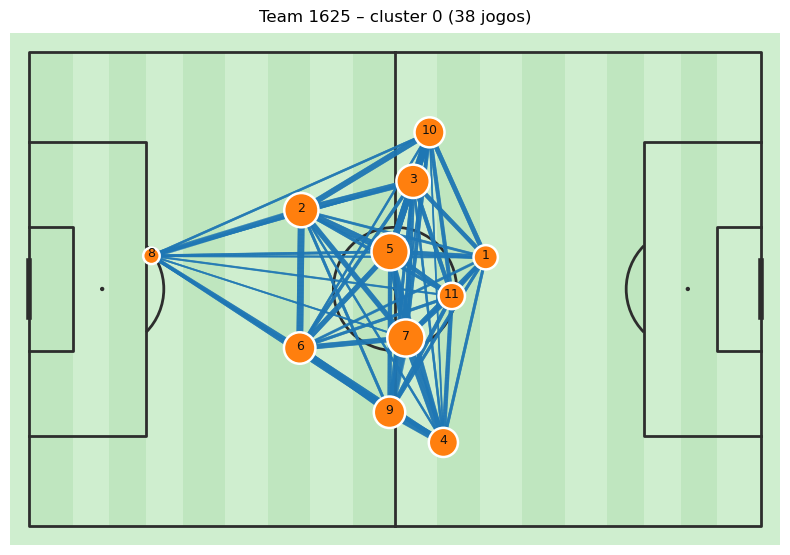

In [7]:
res = robust_season_network(team_id=1627, df_events_net=df_events_net, df_match=df_match,
                            k_formations=1, em_iters=2, weight_by="passes")

for r in res:
    plot_season_slot_network(r["edges"], r["pos"],
        title=f"Team 1625 – cluster {r['cluster']} ({len(r['games'])} jogos)")

Agora, guardar esta network e garantir que podemos replicá-la posteriormente

In [8]:
out_dir = "graphs_csv"
os.makedirs(out_dir, exist_ok=True)

team_id = 1627

for r in res:
    edges_path = f"{out_dir}/team_{team_id}_cluster_{r['cluster']}_edges.csv"
    pos_path   = f"{out_dir}/team_{team_id}_cluster_{r['cluster']}_pos.csv"
    r["edges"].to_csv(edges_path, index=False)
    r["pos"].to_csv(pos_path, index=False)

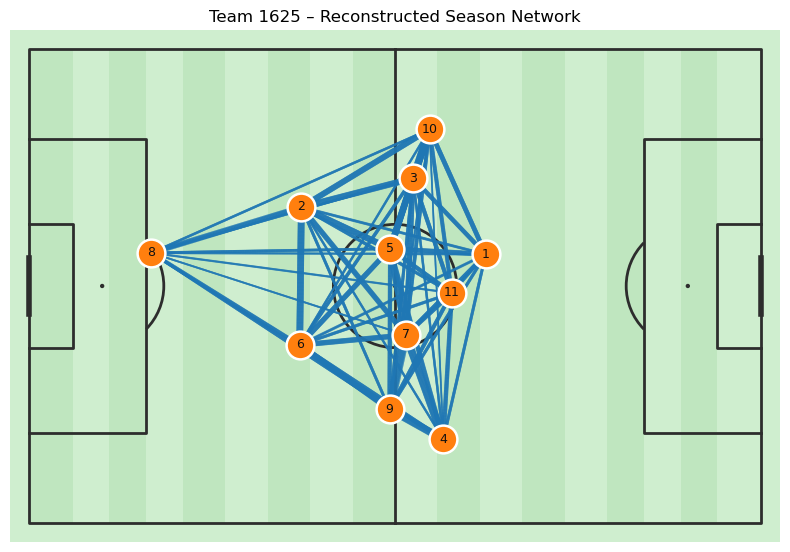

In [9]:
edges = pd.read_csv("graphs_csv/team_1627_cluster_0_edges.csv")
pos   = pd.read_csv("graphs_csv/team_1627_cluster_0_pos.csv")
pos["slot_id"] = pos["slot_id"].astype(int)
pos = pos.set_index("slot_id")[["x","y"]]

# criar pitch
pitch = Pitch(pitch_type="wyscout", pitch_color="#cfeecf", line_color="#2d2d2d",
              stripe=True, stripe_color="#bfe6bf")
fig, ax = pitch.draw(figsize=(8, 12))

# desenhar edges (com espessura proporcional ao nº de passes)
vals = edges["passes"].astype(float)
vmin, vmax = vals.min(), vals.max()
widths = 0.8 + (vals - vmin) * (6.0 - 0.8) / (vmax - vmin + 1e-9)

for (s, d, lw) in zip(edges["src"], edges["dst"], widths):
    x0, y0 = pos.loc[s][["x", "y"]]
    x1, y1 = pos.loc[d][["x", "y"]]
    pitch.lines(x0, y0, x1, y1, ax=ax, lw=float(lw),
                color="#1F77B4", alpha=0.55, zorder=2.5, transparent=True)

# desenhar nós
pitch.scatter(pos["x"], pos["y"], s=400, ax=ax,
              edgecolors="white", linewidths=1.8, zorder =3.5 , facecolors="#FF7F0E")

# rótulos
for s, (x, y) in pos[["x", "y"]].iterrows():
    ax.text(x, y - 1.5, str(int(s)), ha="center", va="top", fontsize=9,zorder = 4.5, color="#111")

ax.set_title("Team 1625 – Reconstructed Season Network", fontsize=12)
plt.show()


Agora vamos aplicar para todas as equipas que possuimos

In [10]:
ids_England = [1625, 1609, 1612, 1624, 1610, 1611, 1619, 1659, 1644, 1631,
    1623, 1673, 10531, 1628, 1613, 1633, 1651, 1646, 1627, 1639]

ids_Italy = [3187, 3172, 3159, 3161, 3158, 3157, 3176, 3164, 3162, 3185,
             3219, 3193, 3166, 3163, 3173, 3165, 3197, 3204, 3315, 3194]

ids_Spain = [676, 675, 687, 684, 680, 692, 714, 682, 701, 679,674, 678,
             677, 691, 683, 756, 712, 695, 696, 698]

ids_France = [3767, 3775, 3766, 3771, 3776, 3772, 3782, 3804, 19830, 3785,
    3774, 3777, 3783, 3787, 3789, 3799, 3770, 3779, 3795, 3780]

ids_Germany = [2444, 2447, 2975, 2446, 2454, 2482, 2450, 2462, 2443, 2455,
    2449, 2451, 2445, 2463, 2457, 2460, 2481, 2453]

ids_WorldCup = [
    9598, 2413, 5629, 4418, 1598, 6380, 15670, 12274, 14358, 6697,
    9905, 12430, 12913, 7047, 15473, 7712, 3148, 16521, 15594, 8493,
    13869, 16276, 17322, 16129, 16216, 16823, 16871, 14855, 19314, 17929,
    7839, 10840]

ids_Euro = [
    9905, 4418, 3148, 10682, 13869, 5629, 1598, 6697, 3757, 2413,
    9598, 10451, 7839, 14496, 9109, 8274, 14622, 14358, 10962, 11944,
    7047, 4687, 8731, 11555]

In [ ]:
COMPETITIONS = {
    "england": ids_England,
    "italy":   ids_Italy,
    "spain":   ids_Spain,
    "france":  ids_France,
    "germany": ids_Germany,
    "worldcup":ids_WorldCup,
    "euro":    ids_Euro,
}

BASE = Path("Data")

def save_team_season(team_id: int, out_dir: Path):
    """Executa k=1 (todos os jogos) e guarda edges/pos em CSV. Ignora equipas sem dados."""
    try:
        res = robust_season_network(
            team_id=team_id,
            df_events_net=df_events_net,
            df_match=df_match,
            k_formations=1,    # 1 cluster = época inteira
            em_iters=2,
            weight_by="passes"
        )
        if not res:
            print(f"[skip] team {team_id}: sem jogos válidos")
            return
        r0 = res[0]
        out_dir.mkdir(parents=True, exist_ok=True)
        r0["edges"].to_csv(out_dir / f"team_{team_id}_edges.csv", index=False)
        r0["pos"].to_csv(  out_dir / f"team_{team_id}_pos.csv",   index=False)
        # opcional: guarda lista de jogos usados
        pd.Series(r0["games"], name="match_id").to_csv(out_dir / f"team_{team_id}_games.csv", index=False)
        print(f"[ok] {out_dir.name} team {team_id} → {len(r0['edges'])} edges, {len(r0['pos'])} nodes")
    except Exception as e:
        print(f"[erro] team {team_id}: {e}")

def process_all():
    for comp, ids in COMPETITIONS.items():
        out_dir = BASE / f"medias_{comp.lower()}"
        print(f"\n=== {comp.upper()} ({len(ids)} equipas) ===")
        for tid in ids:
            save_team_season(int(tid), out_dir)

# correr
process_all()



=== ENGLAND (20 equipas) ===
[ok] medias_england team 1625 → 110 edges, 11 nodes
[ok] medias_england team 1609 → 110 edges, 11 nodes
[ok] medias_england team 1612 → 110 edges, 11 nodes
[ok] medias_england team 1624 → 110 edges, 11 nodes
[ok] medias_england team 1610 → 110 edges, 11 nodes
[ok] medias_england team 1611 → 110 edges, 11 nodes
[ok] medias_england team 1619 → 110 edges, 11 nodes
[ok] medias_england team 1659 → 110 edges, 11 nodes
[ok] medias_england team 1644 → 110 edges, 11 nodes
[ok] medias_england team 1631 → 110 edges, 11 nodes
[ok] medias_england team 1623 → 110 edges, 11 nodes
[ok] medias_england team 1673 → 110 edges, 11 nodes
[ok] medias_england team 10531 → 110 edges, 11 nodes
[ok] medias_england team 1628 → 110 edges, 11 nodes
[ok] medias_england team 1613 → 110 edges, 11 nodes
[ok] medias_england team 1633 → 110 edges, 11 nodes
[ok] medias_england team 1651 → 110 edges, 11 nodes
[ok] medias_england team 1646 → 110 edges, 11 nodes
[ok] medias_england team 1627 → 1